<a href="https://colab.research.google.com/github/elsa9421/GMM_Live_plotting/blob/master/GMM_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from math import pi,cos,sin,sqrt, log
import random             #to use random.random()
#%matplotlib inline
import matplotlib.pyplot as plt
import sys
from scipy.stats.distributions import chi2   #chi2.ppf(0.975, df=2)



## Function to generate multivariate Gaussian distribution with given mean and covariance.

A random vector $X = (X1, X2,..., Xn)^T$ is said to follow a multivariate normal distribution with mean μ and covariance matrix $Σ$ if $X$ can be expressed as
$X = AZ + μ$,
where Σ = $AA^T$ and $Z = (Z1,Z2,...,Zn)$ with $Z_i, i = 1, 2,...,n$ iid $N(0, 1)$
variables.



In [0]:
def mvg(N,d,mu,covarm):
  '''
    USAGE x=mvg(N,d,mu,covarm)

    Generate samples froma multivariate Gaussian distribution with given mean
    and covariance.
    
    Input:
    -N: Number of samples to generate, of type <class, 'int'>
    -d: data dimension, of type <class,'int'>
    -mu: mean, of shape(d,)
    covarm: covariance matrix, of shape (d,d)
    
    Output:
    -x: the function mvg returns an output array of shape (d,N)

   Example: Generate 100 samples from a 2 dimensional multivariate Gaussian 
   distribution with a mean of [5,6]' and a covariance matrix of [3,0;0,8]:
   x=mvg(100,2,[5,6]',[3,0;0,8])
   
   '''
   
   
   
  z=np.random.randn(d,N) #generate independent samples from normal distribution (i.e N(0,1))

  eigVal, eigVec = np.linalg.eig(covarm)

   # apply whitening matrix
   #x=eigVec*sqrt(eigVal)*z + repmat(mu,[1,N]);
  x=np.dot(np.dot(eigVec,np.sqrt(np.diag(eigVal))),z) + mu.reshape(-1,1)
  return x
    
  

In [0]:
def gen_gmm(n):
  ''' The function generates 2D Gaussian Mixture Data 
      
      Input:
      -n : sample size, of type <class,'int'>

      Output:
      -x: of shape(2,n)
  '''
  # Number of Components
  K=3 
  w=np.array([.3,.4,.3])
  #dictionary of numpy array, each of shape (2,)
  mu={0:np.array([0,2]), 1:np.array([1,-3]), 2:np.array([5,0]) } 
  
  theta=pi/8
  G=np.array([[cos(theta),-sin(theta)],[sin(theta),cos(theta)]])
  
  Sig={} #Dictionary for sigma values
  Sig[0]=np.dot(G,np.dot(np.array([[5,0],[0,.1]]),G.conj().T))  #G*[5 0; 0 .1]*G'
  theta = 3*pi/4; 
  G=np.array([[cos(theta),-sin(theta)],[sin(theta),cos(theta)]])
  Sig[1]=np.dot(G,np.dot(np.array([[3,0],[0,.5]]),G.conj().T))  #G*[3 0; 0 .5]*G'
  Sig[2]=np.array([[1,0],[0,4]])

  
  x1 = mvg(n,2,mu[0],Sig[0])
  x2 = mvg(n,2,mu[1],Sig[1])
  x3 = mvg(n,2,mu[2],Sig[2])

  x=np.zeros((2,n))
  for i in range(n):
  # select a component at random
    u=random.random()
    if u < w[0]:
      x[:,i] = x1[:,i];
    elif u < w[0] + w[1]:
      x[:,i] = x2[:,i]
    else:
      x[:,i] = x3[:,i]

  return x


In [0]:
def mvgpdf(x,mu,Sig):
  '''
  Evaluate Multivariate Gaussian pdf
  
  return
  #v = (2*pi)^(-d/2)*(det(Sig)^(-1/2))*exp(-.5*diag((x-repmat(mu,1,n))'*inv(Sig)*(x-repmat(mu,1,n))))';
  '''
  if x.shape==(x.shape[0],):
    x=x.reshape(-1,1)
  d,n=x.shape[0],x.shape[1]
  detSig=np.linalg.det(Sig)
  const=(2*pi)**(-d/2)*(detSig**(-1/2))
  invSig=np.linalg.inv(Sig)
  x_minus_mu=x-mu.reshape(-1,1)
  D=np.dot(np.dot(x_minus_mu.conj().T,invSig),x_minus_mu)
  term2=np.exp(-.5*np.diag(D)).conj().T

  #v = (2*pi)^(-d/2)*(det(Sig)^(-1/2))*exp(-.5*diag((x-repmat(mu,1,n))'*inv(Sig)*(x-repmat(mu,1,n))))';

  
  return const*term2


In [0]:
def train_gmm(x,K):
  '''
  Description:
  - To train GMM with EM algorithm

  Input:
  -x
  -K

  Output:
  -w:
  -mu:
  -Sig:
  -ll:

    '''

  d,n=x.shape

  #initialize

  w=1/K*np.ones((K,))   # np.kron(np.ones((3,)), 1/3) is the python equivalent of repmat(1/3,[1,3])
  p=np.random.permutation(n)  # randomly permute np.arange(x). 
  s=np.std(x,ddof=1)    #https://stackoverflow.com/questions/27600207/why-does-numpy-std-give-a-different-result-to-matlab-std
  mu={}
  Sig={}
  #plt.figure(figsize=(7,7))
  
  
  for k in range(K):
    mu[k]=x[:,p[k]]
    Sig[k]=np.identity(2)*s
  
  

  # Plot Data and initial estimate
  plt.figure(figsize=(7,7))

  plt.plot(x[0,:],x[1,:],'o')
  for k in range(K):
      z = plot_ellipse(mu[k],Sig[k])
      plt.plot(z[0,:],z[1,:])
  
  
   
  
  
  # EM Algorithm
  gam=np.zeros((K,n))
  ll=np.zeros((40,))
  
  for iter in range(100):

    #E Step
    for k in range(K):
      gam[k,:]=w[k]*mvgpdf(x,mu[k],Sig[k])

    gam=np.divide(gam,np.sum(gam,axis=0))

    # M step

    for k in range(K):
      mu[k]= np.divide(np.sum(np.multiply(gam[k,:],x),axis=1),np.sum(gam[k,:]))
      Sig[k]=np.zeros((d,d))
      for i in range(n):
        Sig[k]=Sig[k]+(gam[k,i]*np.outer(x[:,i]-mu[k],x[:,i]-mu[k]))
      Sig[k]=np.divide(Sig[k],np.sum(gam[k,:]))
      w[k]=np.sum(gam[k,:])/n
    
    #compute Log-likelihood
  

    ll[iter]=0
  
    for i in range(n):
      tmp=0
      for k in range(K):
        
        tmp+=w[k]*mvgpdf(x[:,i],mu[k],Sig[k])
      ll[iter]=ll[iter]+log(tmp)
    
    #Plot contours and data
    plt.clf()
    plt.plot(x[0,:],x[1,:],'o')
    
    for k in range(K):
      z=plot_ellipse(mu[k],Sig[k])
      plt.plot(z[0,:],z[1,:])
    
    plt.pause(0.05)
    
    
    
    
    if iter > 1 and (ll[iter] - ll[iter-1]) < .001:
        break
  
  #plt.show()  
    
    
  return w,mu,Sig,ll


In [0]:
def plot_ellipse(m,S):
  '''
  Plot an Elliptical contour of a bivariate Gaussian density

  Input:
  -m:mean
  -S:covariance matrix

  Output:
  -z : ellipse boundary points for plotting using
      >> plot(z[0,:],z[1,:])
  '''

  d=len(m)
  if d!=2:
    sys.exit("Plot ellipse assumes 2D data")
  
  #beta= theoretical mass enclosed
  beta=.9
  r=sqrt(chi2.ppf(beta, df=2))

  #Plot circle
  N=500
  t=np.linspace(0,2*pi,N+1)[:-1]
  u=r*np.array([np.cos(t),np.sin(t)])
  eigVal, eigVec = np.linalg.eig(S)

  z=np.dot(np.dot(eigVec,np.sqrt(np.diag(eigVal))),u) + m.reshape(-1,1)

  return z


In [0]:
def main():
  '''
  main routine for GMM experiment
  '''

  x = gen_gmm(500);
  plt.plot(x[0,:], x[1,:], 'o')
  plt.show()
  w,mu,Sig,ll = train_gmm(x,3)


  plt.plot(ll)





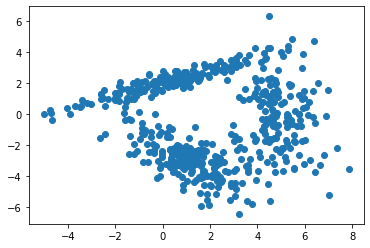

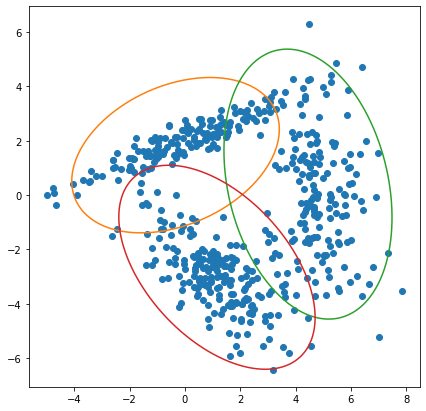

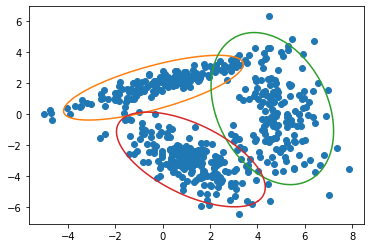

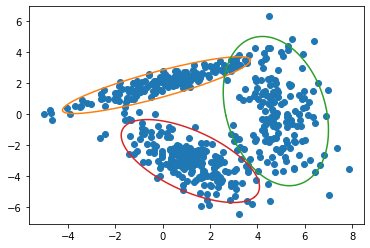

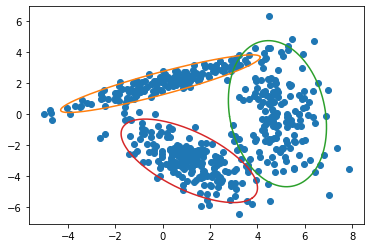

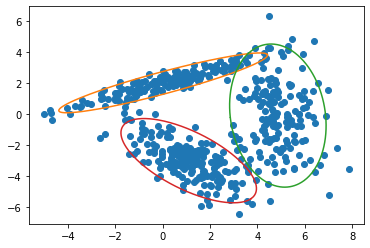

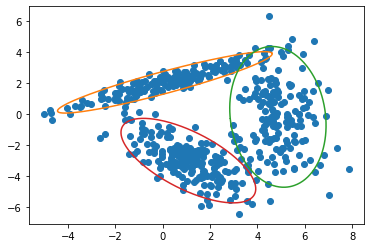

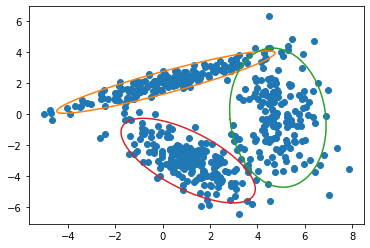

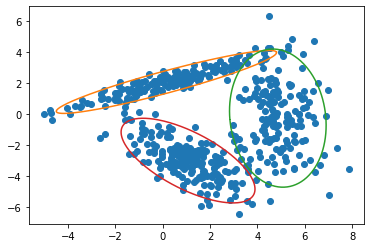

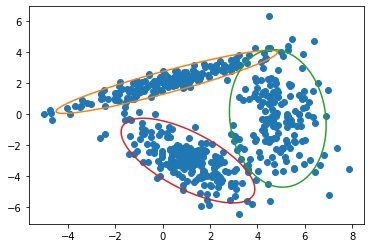

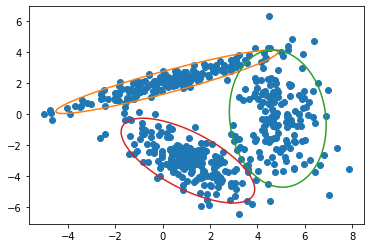

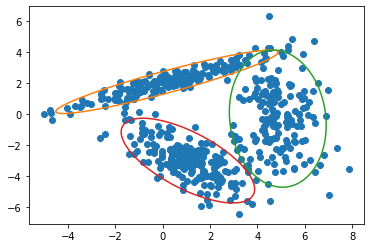

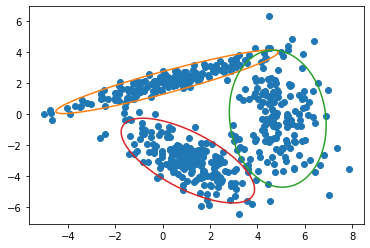

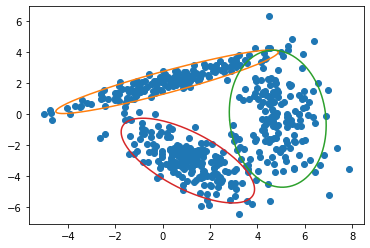

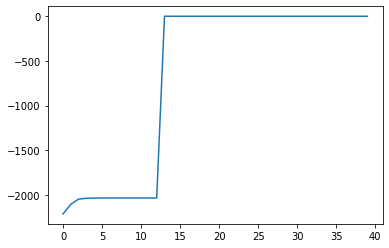

In [8]:
main()